# JupyterHub Notebook

### This notebook server is hosted on the OpenShift platform which provides a separate server for each individual user. The platform takes care of the provisioning of the server and allocating related to storage.


In [1]:
# Install packages that won't be present if this lab is done out of sequence.
!pip3 install seaborn
!pip3 install verta

     |████████████████████████████████| 292 kB 35.9 MB/s            
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
     |████████████████████████████████| 941 kB 33.7 MB/s            
     |████████████████████████████████| 1.0 MB 121.6 MB/s            
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.0.0
    Uninstalling cloudpickle-2.0.0:
      Successfully uninstalled cloudpickle-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elyra 2.2.4 requires jinja2<3.0,>=2.11, but you have jinja2 3.0.3 which is incompatible.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upg

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import watermark
# import s3fs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from minio import Minio
from verta import Client
from minio.error import ResponseError
import os
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

# import tools as tools
%matplotlib inline
%load_ext watermark

In [3]:
%watermark -n -v -m -g -iv


Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.29.0

Compiler    : GCC 8.5.0 20210514 (Red Hat 8.5.0-3)
OS          : Linux
Release     : 4.18.0-305.49.1.el8_4.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

Git hash: 22fd8a54b3169675d01b6e51f397a2ad6d7915e5

seaborn   : 0.11.2
pandas    : 1.3.5
watermark : 2.3.0
matplotlib: 3.5.1
sklearn   : 1.0
numpy     : 1.22.0



## Load Lab parameters

In [4]:
from config import get_params, download_csv_files
user_id,PROJECT_NAME,EXPERIMENT_NAME,experiment_name, s3BucketFullPath = get_params()

STUDENT CONFIGURATION
User ID: "opentlc-mgr"
Project name: "CustomerChurn-opentlc-mgr"
Experiment name: "CustomerChurn-opentlc-mgr", "customerchurn-opentlc-mgr"
S3 Bucket full storage path: "full_data_csv-opentlc-mgr"


In [5]:
def get_s3_server():
    minioClient = Minio('minio-ml-workshop:9000',
                    access_key='minio',
                    secret_key='minio123',
                    secure=False)

    return minioClient

### Read the Merged Data

In [6]:
minioClient = get_s3_server()
download_csv_files(minioClient, s3BucketFullPath)
# data_file = minioClient.fget_object("data", s3BucketFullPath, "/tmp/data.csv")
# data_file_version = data_file.version_id
data = pd.read_csv('/tmp/data.csv')
data.head(5)


<Object: bucket_name: data object_name: b'full_data_csv-opentlc-mgr/_SUCCESS' version_id: None last_modified: 2022-07-27 05:34:20.818000+00:00 etag: d41d8cd98f00b204e9800998ecf8427e size: 0 content_type: None is_dir: False metadata: None >
<Object: bucket_name: data object_name: b'full_data_csv-opentlc-mgr/part-00000-da84c9b5-2e35-489f-ac63-20d3f5c8e08b-c000.csv' version_id: None last_modified: 2022-07-27 05:34:20.731000+00:00 etag: a32b9b7763ecbf458e5ecc1b8fe42c91 size: 923615 content_type: None is_dir: False metadata: None >


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.65,45.65,Yes
1,463,Male,0,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,101.15,385.90,Yes
2,471,Female,1,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,330.60,No
3,496,Male,0,No,No,22,No,No phone service,DSL,No,...,Yes,No,No,Yes,One year,Yes,Bank transfer (automatic),43.75,903.60,Yes
4,833,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.30,No


### Use pandas.DataFrame functions
- _shape_ to return the dimensionality
- _info_ to print a concise summary of the DataFrame
- _describe_ to generate descriptive statistics of the DataFrame's columns
- _isnull().sum()_ to sum the empty values
- finally determine Churn and Total Changes 


In [7]:
data.shape

(7043, 21)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   int64  
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      6958 non-null   object 
 7   MultipleLines     6958 non-null   object 
 8   InternetService   6958 non-null   object 
 9   OnlineSecurity    6958 non-null   object 
 10  OnlineBackup      6958 non-null   object 
 11  DeviceProtection  6958 non-null   object 
 12  TechSupport       6958 non-null   object 
 13  StreamingTV       6958 non-null   object 
 14  StreamingMovies   6958 non-null   object 
 15  Contract          6958 non-null   object 
 16  PaperlessBilling  6958 non-null   object 


In [9]:
data.describe()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,6958.000000,6947.000000
mean,3522.000000,0.162147,32.371149,64.712432,2281.858860
std,2033.283305,0.368612,24.559481,30.106685,2266.307446
min,1.000000,0.000000,0.000000,18.250000,18.800000
25%,1761.500000,0.000000,9.000000,35.412500,400.700000
50%,3522.000000,0.000000,29.000000,70.350000,1396.250000
75%,5282.500000,0.000000,55.000000,89.850000,3790.400000
max,7043.000000,1.000000,72.000000,118.750000,8684.800000


In [10]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService        85
MultipleLines       85
InternetService     85
OnlineSecurity      85
OnlineBackup        85
DeviceProtection    85
TechSupport         85
StreamingTV         85
StreamingMovies     85
Contract            85
PaperlessBilling    85
PaymentMethod       85
MonthlyCharges      85
TotalCharges        96
Churn               85
dtype: int64

Text(0, 0.5, 'Count')

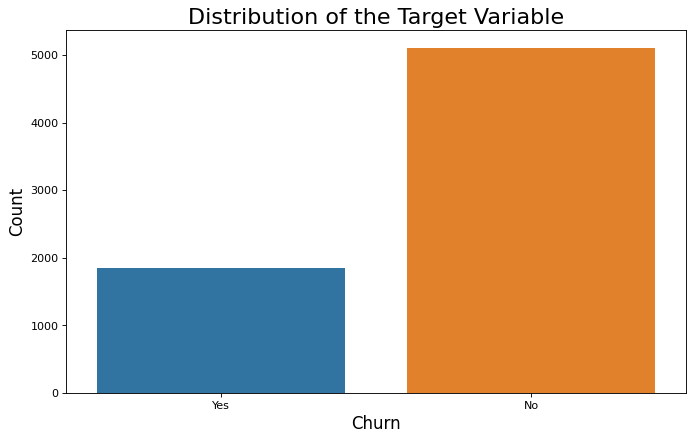

In [11]:
fig = plt.figure(figsize=(10,6), dpi=80)
ax = sns.countplot(x="Churn", data=data)
ax.set_title('Distribution of the Target Variable', fontsize=20)
ax.set_xlabel('Churn', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)

In [12]:
# Convert binary variable into numeric so plotting is easier. We need to later take mean
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

Text(0.5, 1.0, 'Churn count by Contract')

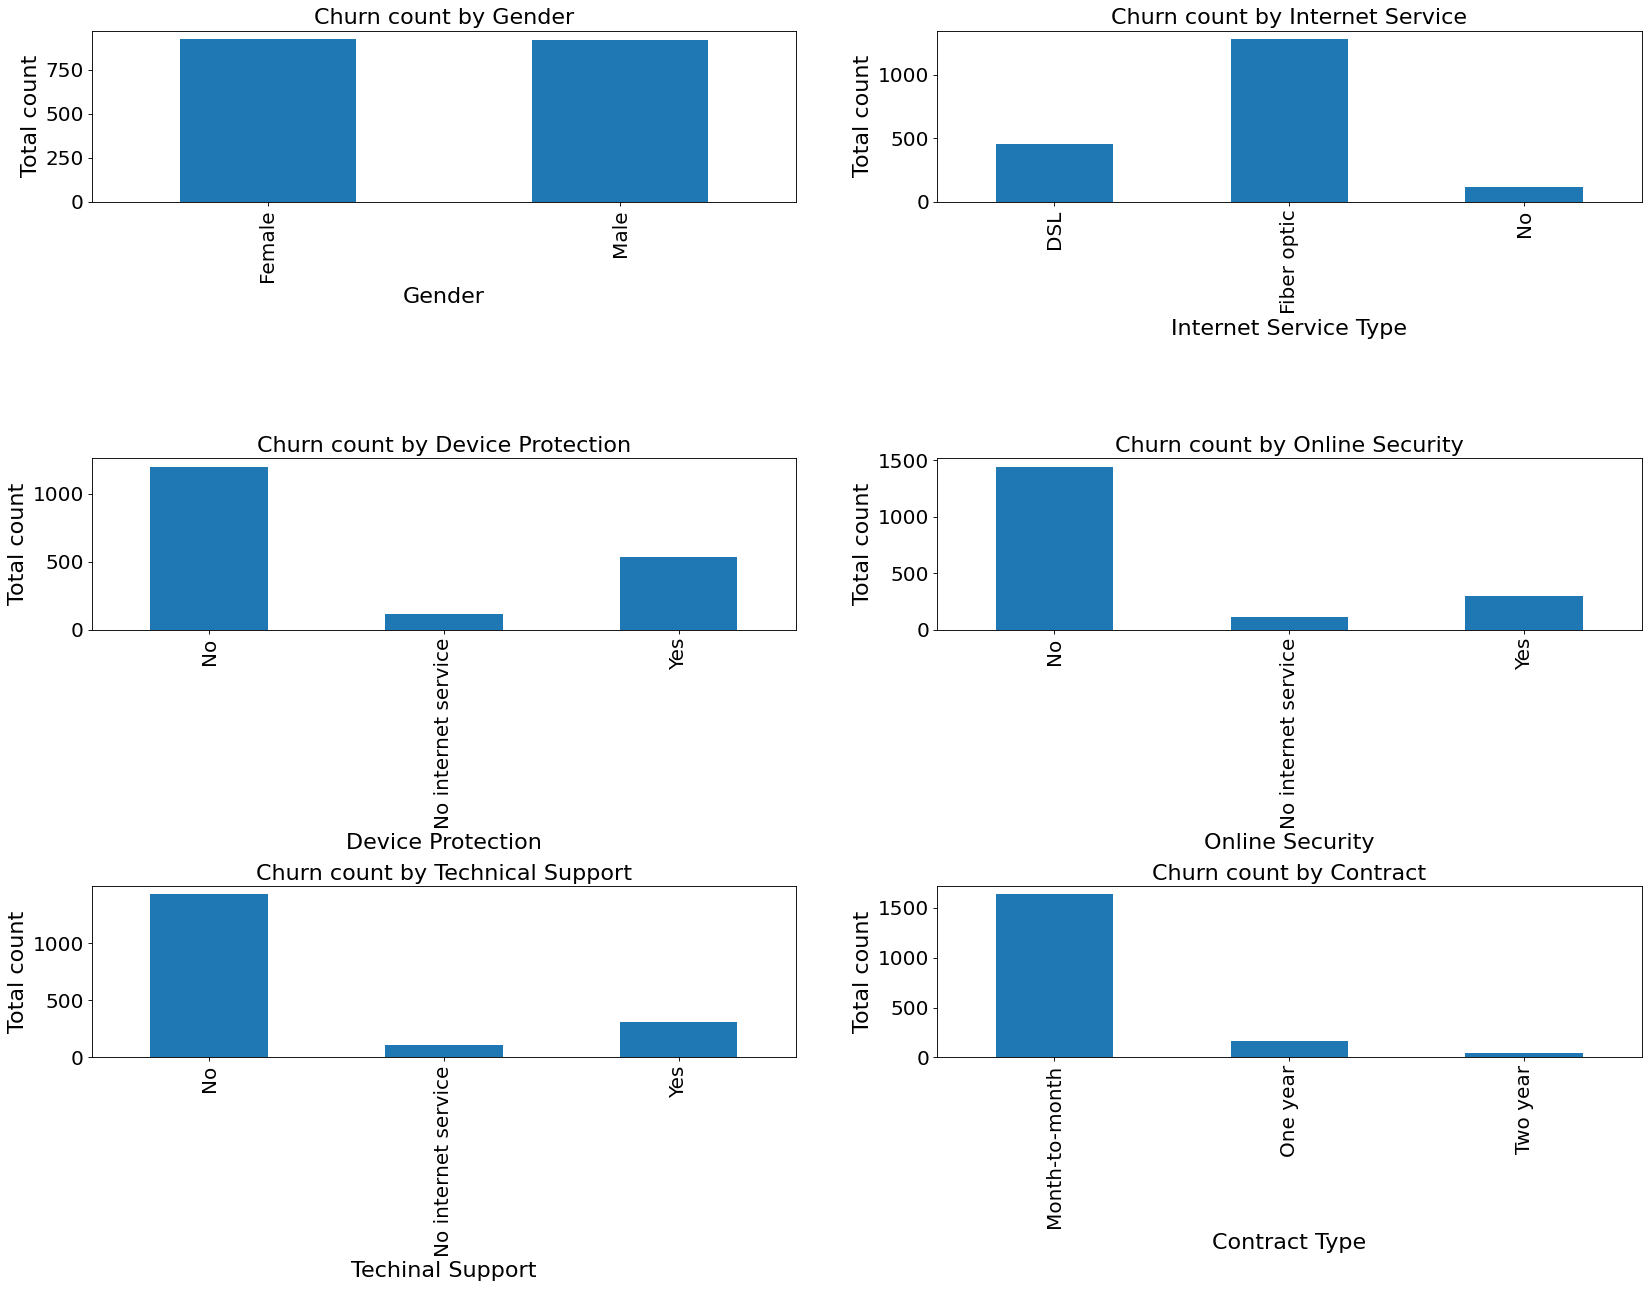

In [13]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(25,17), dpi = 80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None ,wspace=None, hspace=1.5)
plt.rc('xtick', labelsize = 12)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 12)

data.groupby('gender').Churn.sum().plot(kind='bar', ax = ax1)
ax1.set_ylabel('Total count',fontsize = 20)
ax1.set_xlabel('Gender',fontsize = 20)
ax1.tick_params(labelsize = 18)
ax1.set_title('Churn count by Gender',fontsize = 20)

data.groupby('InternetService').Churn.sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Total count',fontsize = 20)
ax2.set_xlabel('Internet Service Type',fontsize = 20)
ax2.tick_params(labelsize = 18)
ax2.set_title('Churn count by Internet Service',fontsize = 20)

data.groupby('DeviceProtection').Churn.sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Total count',fontsize = 20)
ax3.set_xlabel('Device Protection',fontsize = 20)
ax3.tick_params(labelsize = 18)
ax3.set_title('Churn count by Device Protection',fontsize = 20)

data.groupby('OnlineSecurity').Churn.sum().plot(kind='bar', ax=ax4)
ax4.set_ylabel('Total count',fontsize = 20)
ax4.set_xlabel('Online Security',fontsize = 20)
ax4.tick_params(labelsize = 18)
ax4.set_title('Churn count by Online Security',fontsize = 20)

data.groupby('TechSupport').Churn.sum().plot(kind='bar',ax=ax5)
ax5.set_ylabel('Total count',fontsize = 20)
ax5.set_xlabel('Techinal Support',fontsize = 20)
ax5.tick_params(labelsize = 18)
ax5.set_title('Churn count by Technical Support',fontsize = 20)

data.groupby('Contract').Churn.sum().plot(kind='bar',ax=ax6)
ax6.set_ylabel('Total count',fontsize = 20)
ax6.set_xlabel('Contract Type',fontsize = 20)
ax6.tick_params(labelsize = 18)
ax6.set_title('Churn count by Contract',fontsize = 20)


In [14]:
data.replace(" ", np.nan, inplace=True)

In [15]:
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService        85
MultipleLines       85
InternetService     85
OnlineSecurity      85
OnlineBackup        85
DeviceProtection    85
TechSupport         85
StreamingTV         85
StreamingMovies     85
Contract            85
PaperlessBilling    85
PaymentMethod       85
MonthlyCharges      85
TotalCharges        96
Churn               85
dtype: int64

In [16]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [17]:
mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)
# Now we know that total charges has nan values
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Text(34.2537422839506, 0.5, 'Total Charges')

<Figure size 800x640 with 0 Axes>

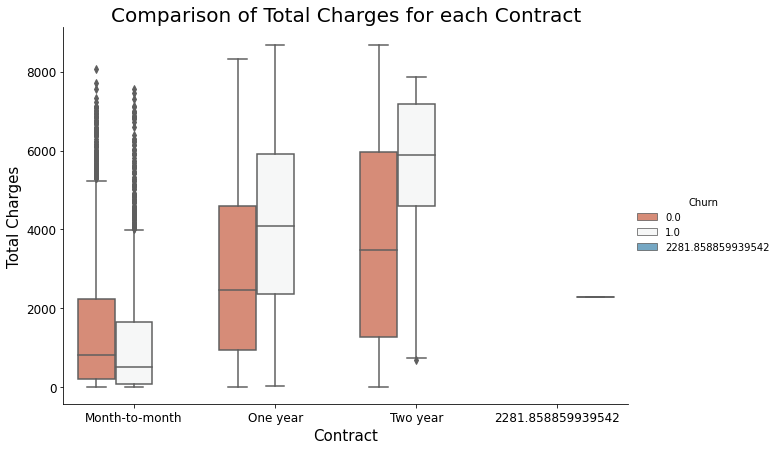

In [18]:
plt.figure(figsize=(10,8), dpi=80)
# Sns.set(rc={'figure.figsize':(25,15)})
ax = sns.catplot(x="Contract", y="TotalCharges", hue="Churn", kind="box", data=data, height = 6,aspect = 1.5,palette = 'RdBu')
plt.title('Comparison of Total Charges for each Contract',fontsize = 20)
plt.xlabel('Contract',fontsize = 15)
plt.ylabel('Total Charges',fontsize = 15)